## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import random
from itertools import chain
import sklearn.model_selection as skl
import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import binarize

#static variables
random_state = 40
num_epochs = 50

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
59144,00014626_040.png,Infiltration,40,14626,45,F,AP,3056,2544,0.139,0.139,NaN,/data/images_007/images/00014626_040.png
63730,00015732_012.png,No Finding,12,15732,47,F,PA,2366,2621,0.143,0.143,NaN,/data/images_007/images/00015732_012.png
32868,00008598_005.png,Effusion,5,8598,52,F,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008598_005.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_diseases = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_diseases = [disease for disease in all_diseases if disease != 'No Finding']
for disease in all_diseases:
    all_xray_df[disease] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if disease in x else 0)
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3162,00000830_002.png,No Finding,2,830,51,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7791,00002048_008.png,No Finding,8,2048,42,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68578,00016934_029.png,No Finding,29,16934,56,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32448,00008480_005.png,No Finding,5,8480,16,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88912,00022052_000.png,No Finding,0,22052,56,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia class'] = all_xray_df['Pneumonia'].map(lambda x: '1' if x==1.0 else '0')
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia class
56112,00013999_007.png,No Finding,7,13999,55,M,PA,2550,2951,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
28084,00007321_013.png,Effusion|Nodule,13,7321,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
7186,00001900_027.png,Pneumothorax,27,1900,52,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
87767,00021700_009.png,Pneumothorax,9,21700,58,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
65244,00016103_009.png,No Finding,9,16103,65,M,PA,2878,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(vargs, test_size=0.2, stratify=vargs['pneumonia class'],
                                               random_state = random_state)
    
    # to have equal amount of positive and negative cases of pneumonia in training dataset
    pos_inds = train_data[train_data['pneumonia class']=='1'].index.tolist()
    neg_inds = train_data[train_data['pneumonia class']=='0'].index.tolist()
    random.seed(random_state)
    neg_inds_sample = random.sample(neg_inds, len(pos_inds))
    train_data = train_data.loc[pos_inds + neg_inds_sample]
    
    # to have 4 times bigger the negative cases in the validation dataset
    # Validation dataset has 20% prevalence of pneumonial to mirror real clinical scenario
    val_pos_inds = val_data[val_data['pneumonia class']=='1'].index.tolist()
    val_neg_inds = val_data[val_data['pneumonia class']=='0'].index.tolist()
    val_neg_inds_sample = random.sample(val_neg_inds, 4*len(val_pos_inds))
    val_data = val_data.loc[val_pos_inds + val_neg_inds_sample]
    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(all_xray_df)

positive_cases_training = 100*(train_data[train_data['pneumonia class']=='1'].count()[0]/len(train_data))
print('Percentage of positive cases in the training dataset: %d '%positive_cases_training)

negative_cases_training = 100*(train_data[train_data['pneumonia class']=='0'].count()[0]/len(train_data))
print('Percentage of negative cases in the training dataset: %d'%negative_cases_training)

positive_cases_validation = 100*(val_data[val_data['pneumonia class']=='1'].count()[0]/len(val_data))
print('Percentage of positive cases in the validation dataset: %d'%positive_cases_validation)

negative_cases_validation = 100*(val_data[val_data['pneumonia class']=='0'].count()[0]/len(val_data))
print('Percentage of negative cases in the validation dataset: %d'%negative_cases_validation)

Percentage of positive cases in the training dataset: 50 
Percentage of negative cases in the training dataset: 50
Percentage of positive cases in the validation dataset: 20
Percentage of negative cases in the validation dataset: 80


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(rescale=1.0/255.0,
                                   horizontal_flip = True,
                                   vertical_flip = False,
                                   height_shift_range= 0.1,
                                   width_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range = 0.1,
                                   zoom_range=0.1)
    
    val_idg = ImageDataGenerator(rescale=1.0/255.0)
    
    return train_idg, val_idg


def make_train_gen(train_data,train_idg):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    img_size = (224, 224)
    train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia class',
                                         class_mode = 'binary',
                                         target_size = img_size, 
                                         batch_size = 32)
    return train_gen


def make_val_gen(val_data, val_idg):
    img_size = (224, 224)
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia class',
                                             class_mode = 'binary',
                                             target_size = img_size, 
                                             batch_size = len(val_data)) 
    
    return val_gen

In [8]:
train_idg, val_idg = my_image_augmentation()
train_gen = make_train_gen(train_data, train_idg)
val_gen = make_val_gen(val_data, val_idg)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [9]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

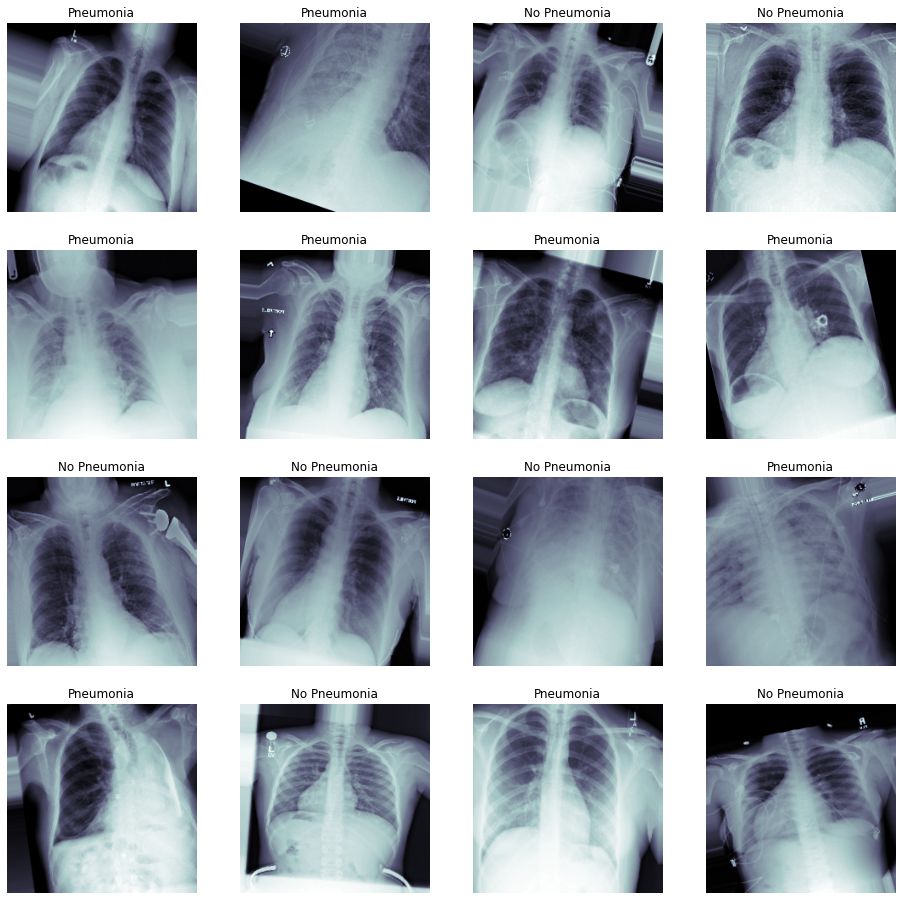

In [10]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

In [12]:
vgg_model = load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 10s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

In [13]:
for layer in vgg_model.layers[0:17]:
        layer.trainable = False

In [14]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [15]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    # initialize the model
    my_model = Sequential()
    # add the convolutional part of the VGG model
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [16]:
my_model = build_my_model(vgg_model)
my_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
my_model.fit_generator(train_gen, validation_data = (valX, valY), epochs=5)

Epoch 1/5
72/72 [==============================] - 80s 1s/step - loss: 0.8715 - binary_accuracy: 0.5017 - val_loss: 0.7052 - val_binary_accuracy: 0.4965
Epoch 2/5
72/72 [==============================] - 63s 879ms/step - loss: 0.7526 - binary_accuracy: 0.5144 - val_loss: 0.7635 - val_binary_accuracy: 0.2517
Epoch 3/5
72/72 [==============================] - 63s 881ms/step - loss: 0.7110 - binary_accuracy: 0.5541 - val_loss: 0.7673 - val_binary_accuracy: 0.2678
Epoch 4/5
72/72 [==============================] - 63s 869ms/step - loss: 0.7028 - binary_accuracy: 0.5336 - val_loss: 0.7270 - val_binary_accuracy: 0.4245
Epoch 5/5
72/72 [==============================] - 61s 844ms/step - loss: 0.6922 - binary_accuracy: 0.5585 - val_loss: 0.7918 - val_binary_accuracy: 0.2657


In [17]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo    
weight_path="{}_my_model.best.hdf5".format('pneumonia_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]


### Start training! 

In [18]:
## train your model

# Todo
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = num_epochs, 
                          callbacks = callbacks_list)

Epoch 1/50
72/72 [==============================] - 71s 980ms/step - loss: 0.6844 - binary_accuracy: 0.5624 - val_loss: 0.6982 - val_binary_accuracy: 0.5196

Epoch 00001: val_loss improved from inf to 0.69817, saving model to pneumonia_class_my_model.best.hdf5
Epoch 2/50
72/72 [==============================] - 62s 863ms/step - loss: 0.6808 - binary_accuracy: 0.5651 - val_loss: 0.7309 - val_binary_accuracy: 0.4510

Epoch 00002: val_loss did not improve from 0.69817
Epoch 3/50
72/72 [==============================] - 62s 855ms/step - loss: 0.6755 - binary_accuracy: 0.5803 - val_loss: 0.6515 - val_binary_accuracy: 0.5727

Epoch 00003: val_loss improved from 0.69817 to 0.65146, saving model to pneumonia_class_my_model.best.hdf5
Epoch 4/50
72/72 [==============================] - 62s 858ms/step - loss: 0.6686 - binary_accuracy: 0.5769 - val_loss: 0.6182 - val_binary_accuracy: 0.6329

Epoch 00004: val_loss improved from 0.65146 to 0.61817, saving model to pneumonia_class_my_model.best.hdf5


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

1430/1430 [==============================] - 13s 9ms/step


In [36]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    fpr, tpr, thr = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = 'AUC = %0.3f' %(auc(fpr,tpr)))
    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('AUC')
    ax.legend(loc='best')
    return

## what other performance statistics do you want to include here besides AUC? 

def prec_recall_plot(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    fig, ax = plt.subplots(1,1, figsize = (7, 7))
    ax.plot(recall, precision)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    return

def f1_plot(t_y, p_y):
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    precision, recall, thr = precision_recall_curve(t_y, p_y)
    f1s = [f1_score(t_y, binarize(p_y, ind)) for ind in thr]
    ax.plot(thr, f1s, label='F1 score')
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 score')
    ax.legend()
    ax.set_title('F1 socre vs Threshold')
    return

#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    x_values = np.arange(0, len(history.history["loss"]))
    metrics = ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    markers = ['k-', 'r-', 'b-', 'g-']
    plt.figure(figsize=(7,7))
    for i, metric in enumerate(metrics):
        plt.plot(x_values, history.history[metric], markers[i], label = labels[i])
    plt.title('Training and validation Loss & Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend(loc='best')   
    
    return

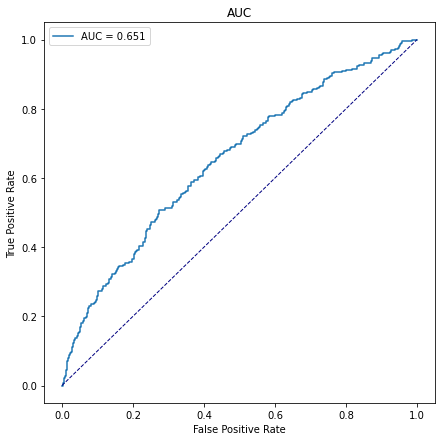

In [31]:
## plot figures

# Todo
plot_auc(valY, pred_Y)

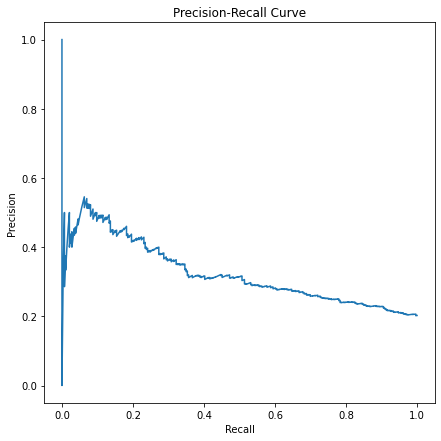

In [27]:
prec_recall_plot(valY,pred_Y)

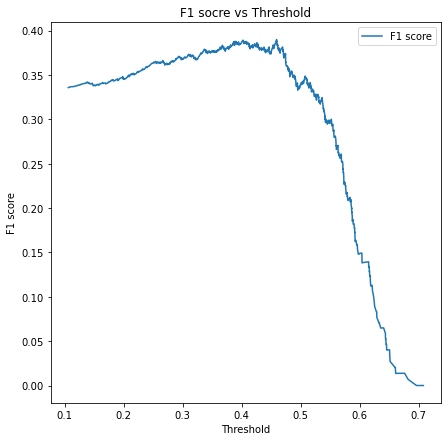

In [26]:
f1_plot(valY,pred_Y)

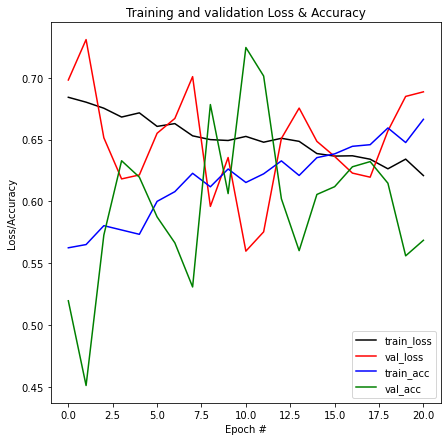

In [37]:
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [49]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
f1_score = 2*(precision*recall)/(precision+recall)
print('Max F1 score: ',max(f1_score))
best_th_index = np.nanargmax(f1_score)
print('Index: ', best_th_index)
best_th = thresholds[best_th_index]
print('Best threshold: ', best_th)
print('Precision: ', precision[best_th_index])
print('Recall: ', recall[best_th_index])

Max F1 score:  0.3897849462365591
Index:  955
Best threshold:  0.45900106
Precision:  0.3165938864628821
Recall:  0.506993006993007


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


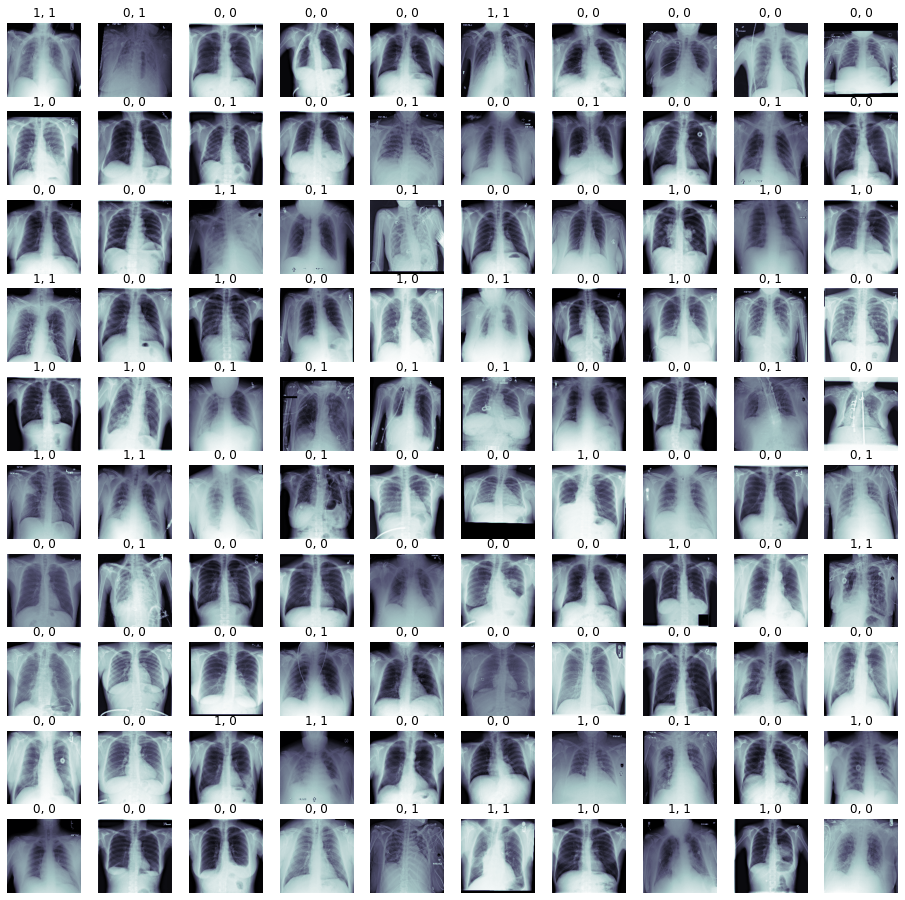

In [51]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > best_th:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > best_th: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [52]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)